# Neural Network Implementation of Discrete Fourier Transform

## Importing Necessary Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dft(x):
    return torch.fft.fft(x)

## Generation of Training Data

In [3]:
torch.manual_seed(42) #seed used for simulation replication
data_size = 500
N = 10 #fixed_length of DFT
data_input = np.random.uniform(low=-20, high=20, size = (data_size, N)) #Generate input data
data_output = np.zeros((data_size, N), dtype = np.complex64)

# Calculate respective output data using built-in function
for i in range(data_size):
    data_output[i] = dft(torch.tensor(data_input[i]))

data_output_real = data_output.real
data_output_imag = data_output.imag

data_output_nn = np.hstack((data_output_real, data_output_imag))

<span style ="font-family:cursive; font-size: 90%">
1. Output of NN is flattened by concatenating real part of DFT with imaginary part of DFT, that is, for each N-length input, output is 2N-length. <br/>
2. Each row of data_output_nn now corresponds to DFT of each row of data_input, respectively

## Model Definition

In [4]:
class linear_nn(nn.Module):
    def __init__(self, input_size, output_size):
        super(linear_nn,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, output_size))
        
    #Forward propagation
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

<span style ="font-family:cursive; font-size: 90%">
With prior knowledge that DFT is a linear transformation, we train a linear NN to model it
</span>

In [5]:
input_size = N
output_size = 2*N
linear_model = linear_nn(input_size, output_size)

#80% datasets are used for training, 20% for testing
train_size = int(0.8 * data_size)

#Mean-Squared Error loss function
loss_fcn = nn.MSELoss()
learning_rate = 0.01     #Hyper-parameter

#Stochastic Gradient Descent Alogrithm optimizer
optimizer = optim.SGD(linear_model.parameters(), lr = learning_rate)

training_loss = []

In [6]:
data_input_tensor = torch.FloatTensor(data_input)
data_output_tensor = torch.FloatTensor(data_output_nn)

## Model Training

In [7]:
n_epochs = 200
for epoch in range(n_epochs):
    linear_model.train()   #Model is set to be in training mode
    training_error = 0
    
    for i in range(train_size):
        predicted_output = linear_model(data_input_tensor[i])
        
        #MSE error between prediction from nn and expected output
        loss = loss_fcn(predicted_output, data_output_tensor[i])
        training_error = training_error + loss.item()
        
        #Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #Average of individual losses over training size
    training_error = training_error/train_size
    training_loss.append(training_error)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Training Error: {training_error}")

Epoch: 10, Training Error: 0.0001265338903366542
Epoch: 20, Training Error: 5.1647478483468274e-08
Epoch: 30, Training Error: 3.886883678902876e-11
Epoch: 40, Training Error: 1.4894964961409927e-11
Epoch: 50, Training Error: 1.5118938454699095e-11
Epoch: 60, Training Error: 1.494217555350792e-11
Epoch: 70, Training Error: 1.4687149466996278e-11
Epoch: 80, Training Error: 1.4489299308972914e-11
Epoch: 90, Training Error: 1.5073247410435016e-11
Epoch: 100, Training Error: 1.4178896635356347e-11
Epoch: 110, Training Error: 1.4703148044242256e-11
Epoch: 120, Training Error: 1.635480071249945e-11
Epoch: 130, Training Error: 1.471631689718613e-11
Epoch: 140, Training Error: 1.479529255132752e-11
Epoch: 150, Training Error: 1.511641578892057e-11
Epoch: 160, Training Error: 1.4938458511100545e-11
Epoch: 170, Training Error: 1.440388679749098e-11
Epoch: 180, Training Error: 1.4682216259833193e-11
Epoch: 190, Training Error: 1.4819112893185368e-11
Epoch: 200, Training Error: 1.511624951242279e-1

## Plotting Training Error vs Epoch

Text(0.5, 1.0, 'Training Error over Epochs')

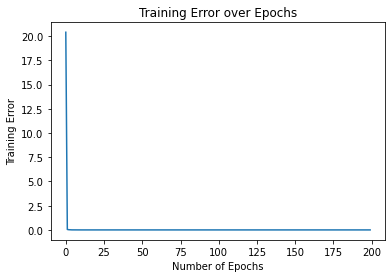

In [28]:
plt.plot(training_loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Error")
plt.title("Training Error over Epochs")

In [29]:
linear_model.eval()

linear_nn(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
  )
)

## Model Testing

In [30]:
test_input = data_input_tensor[train_size + 1 : ]
test_output = data_output_tensor[train_size + 1 : ]
predicted_output = linear_model(test_input)
loss = loss_fcn(predicted_output,test_output)

test_error = loss.item()
print(f"Test Error: {test_error}")

Test Error: 1.311729978109577e-11


<span style ="font-family:cursive; font-size: 90%">
Significantly low test error, the trained NN can be used as an approximate model for the required transformation
</span>

## Verifying that weights give DFT Matrix

<span style ="font-family:cursive; font-size: 90%">
Since the model is linear, the trained weights essentially give us the DFT matrix for given length N.
</span>

In [31]:
weight = torch.transpose(linear_model.layers[0].weight, 0, 1)
DFT_matrix = weight[:,0:N] + weight[:,N:2*N]*1j
DFT_matrix

tensor([[ 1.0000+9.4949e-39j,  1.0000+1.4067e-08j,  1.0000+1.0233e-09j,
          1.0000-3.6180e-08j,  1.0000+5.5649e-08j,  1.0000+1.8538e-38j,
          1.0000-1.6712e-07j,  1.0000+1.4377e-09j,  1.0000-4.5367e-08j,
          1.0000-1.4379e-08j],
        [ 1.0000-2.9175e-39j,  0.8090-5.8779e-01j,  0.3090-9.5106e-01j,
         -0.3090-9.5106e-01j, -0.8090-5.8779e-01j, -1.0000-5.6961e-39j,
         -0.8090+5.8779e-01j, -0.3090+9.5106e-01j,  0.3090+9.5106e-01j,
          0.8090+5.8779e-01j],
        [ 1.0000+3.9536e-39j,  0.3090-9.5106e-01j, -0.8090-5.8779e-01j,
         -0.8090+5.8779e-01j,  0.3090+9.5106e-01j,  1.0000+7.7191e-39j,
          0.3090-9.5106e-01j, -0.8090-5.8779e-01j, -0.8090+5.8779e-01j,
          0.3090+9.5106e-01j],
        [ 1.0000+1.7178e-38j, -0.3090-9.5106e-01j, -0.8090+5.8779e-01j,
          0.8090+5.8779e-01j,  0.3090-9.5106e-01j, -1.0000+3.3538e-38j,
          0.3090+9.5106e-01j,  0.8090-5.8779e-01j, -0.8090-5.8779e-01j,
         -0.3090+9.5106e-01j],
        [ 1.

## Calculating DFT using trained model

In [34]:
def calculate_DFT(x):
    dft_concat = linear_model(torch.FloatTensor(x)).detach().numpy()
    return dft_concat[0:N] + dft_concat[N:2*N]*1j

<span style ="font-family:cursive; font-size: 90%">
calculate_DFT uses trained NN implementation to calculate DFT of a fixed length input data
</span>

### Example

In [35]:
dft_input = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dft_output = calculate_DFT(dft_input)
dft_output

array([55.       +8.2555717e-37j, -4.9999995+1.5388417e+01j,
       -5.0000024+6.8819098e+00j, -4.999999 +3.6327136e+00j,
       -5.000002 +1.6245987e+00j, -5.000007 +1.6118234e-36j,
       -5.000002 -1.6245968e+00j, -4.9999995-3.6327128e+00j,
       -5.       -6.8819098e+00j, -4.999999 -1.5388415e+01j],
      dtype=complex64)